# やること

- ~~BuckConverterCell を v_s, u(t) に対応させる~~
- ~~学習データ 1 種類~~
  - ~~定常状態だけを使う~~
- 学習データとは離れたデータでテストし、正しく推論できるか確認

※ v_C と v_o は同じである\
このノートブックでは、v_C に統一して記述する


In [8]:
# 各種のインポート
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# モデルの定義

### note4.ipynb からの変更点

- class 名を BuckConverterCell から BuckConverter に変更
  - 一つのセルだけじゃなく、時系列シミュレーションを行えるように拡張したため
- forward メソッドを cell_forward に変更
- forward メソッドを追加し、時系列シミュレーションを行えるように拡張
- 引数を v_p から v_s, u(t)に変更
  - オイラー法の更新式に対応するため

\begin{cases}
i_L(t + \Delta t) = i_L(t) + \dfrac{dt}{L}\bigl(v_s , u(t) - v_C(t)\bigr)\\\
v_C(t + \Delta t) = v_C(t) + \dfrac{dt}{C}\Bigl(i_L(t + \Delta t) - \dfrac{v_C(t)}{R}\Bigr)
\end{cases}


In [9]:
class BuckConverter(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt

        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    # --- 1ステップ更新 ---
    def cell_forward(
        self, h: torch.Tensor, v_p: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Inputs:
            h: [batch, 2] - [i_L, v_C]
            v_p: [batch, 1] - スイッチノード電圧 v_p(t) = v_s * u(t)

        Outputs:
            - 次ステップ状態 [i_L_next, v_C_next]
            - 実効スイッチノード電圧 v_p_eff
        """
        i_L = h[:, 0]
        v_C = h[:, 1]
        Vp = v_p[:, 0]

        # パラメータ（正の値保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)
        dt = self.dt

        # --- DCM対応 ---
        # スイッチOFF & 電流が0以下なら v_p = v_C（ダイオードクランプ）
        idx_dcm = (Vp < 1e-9) & (i_L <= 0)
        Vp = torch.where(idx_dcm, v_C, Vp)
        v_p_eff = Vp.clone()

        # --- 半陰的オイラー更新 ---
        i_L_next = i_L + (dt / L) * (Vp - v_C)
        i_L_next = torch.relu(i_L_next)  # DCMで負電流を抑制
        v_C_next = v_C + (dt / C) * (i_L_next - v_C / R)

        return torch.stack([i_L_next, v_C_next], dim=1), v_p_eff

    # --- 時系列シミュレーション ---
    def forward(
        self, v_s: float, u: torch.Tensor, h0: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Inputs:
            v_s: float - 入力電圧（一定）
            u: [batch, seq_len, 1] - スイッチ信号系列 u(t)
            h0: [batch, 2] - 初期状態 [i_L, v_C]

        Outputs:
            h_seq: [batch, seq_len, 2]
            v_p_eff_seq: [batch, seq_len]
        """
        v_p = (v_s * u).clone()  # [batch, seq_len, 1]
        h_seq = []
        v_p_eff_seq = []

        h = h0
        for t in range(v_p.shape[1]):
            h, v_p_eff = self.cell_forward(h, v_p[:, t, :])
            h_seq.append(h)
            v_p_eff_seq.append(v_p_eff)

        h_seq = torch.stack(h_seq, dim=1)
        v_p_eff_seq = torch.stack(v_p_eff_seq, dim=1)
        return h_seq, v_p_eff_seq

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }


# 学習データをシミュレーションによって作成

BuckConverter クラスを使って 1 つの学習データを生成


In [10]:
# ===== 真値パラメータ =====
L_true = 50e-6
C_true = 1000e-6
R_true = 3

dt = 5e-7
Vin = 28
Vref = 6
duty = Vref / Vin

Tsim = 0.1  # シミュレーション時間(s)
steps = int(Tsim / dt)  # サンプリング数
f_sw = 20e3  # スイッチング周波数
period = int(1 / f_sw / dt)  # 1周期あたりのサンプル数
print(f"1周期あたりのサンプル数: {period}")

# ===== PWM波形生成 =====
t = np.arange(0, steps) * dt
u = np.zeros(steps)
for j in range(steps):
    u[j] = 1 if j % period < period * duty else 0

# Torchテンソル化（[batch, seq_len, 1]）
u_t = torch.tensor(u, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

# ===== モデル作成 =====
model = BuckConverter(dt=dt, L_init=L_true, C_init=C_true, R_init=R_true)

# ===== シミュレーション実行 =====
with torch.no_grad():
    h_current = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    h_seq, v_p_eff_seq = model(Vin, u_t, h_current)

# ===== 結果抽出 =====
va = v_p_eff_seq[0, :].numpy()
il = h_seq[0, :, 0].numpy()
vc = h_seq[0, :, 1].numpy()


1周期あたりのサンプル数: 100


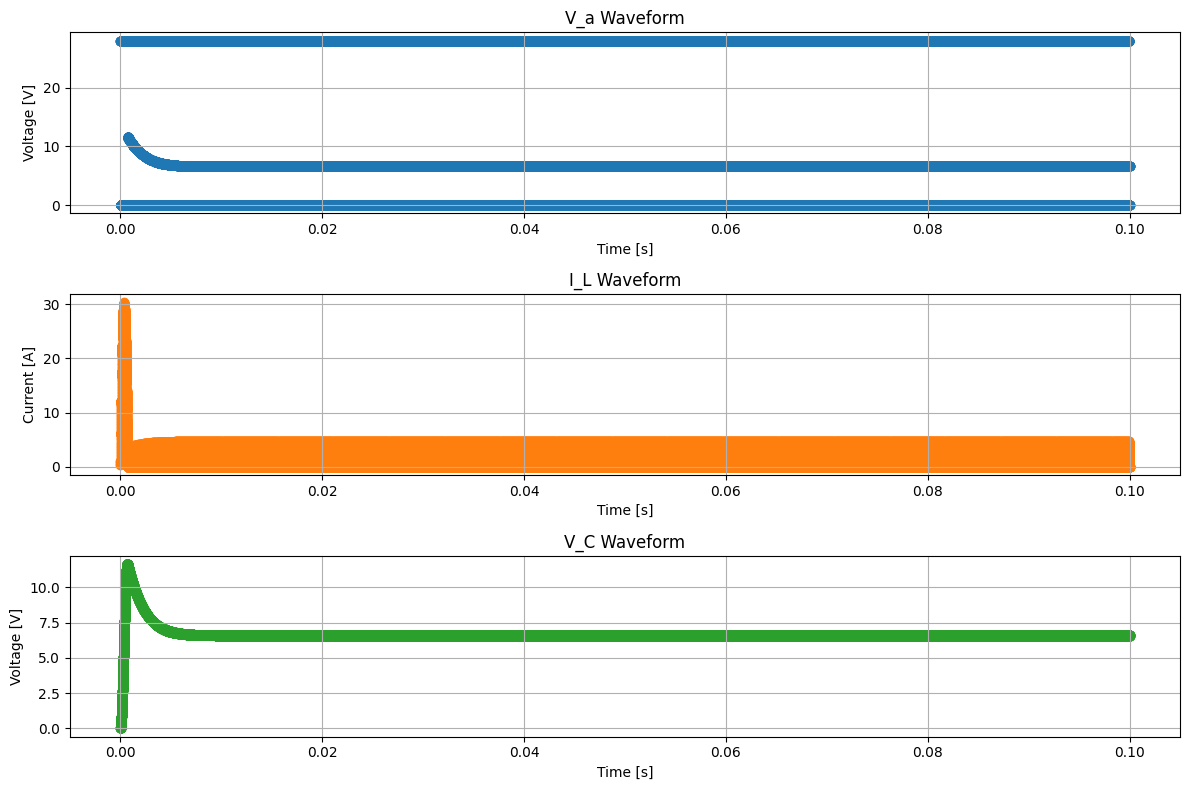

In [11]:
# 独立変数（時間）の生成
time = np.arange(0, steps * dt, dt)
n_plot = 0

# 描画
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].scatter(time[-n_plot:], va[-n_plot:], label="va(t)")
axs[0].set_title("V_a Waveform")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Voltage [V]")
axs[0].grid(True)

axs[1].scatter(time[-n_plot:], il[-n_plot:], label="iL(t)", color="tab:orange")
axs[1].set_title("I_L Waveform")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Current [A]")
axs[1].grid(True)

axs[2].scatter(time[-n_plot:], vc[-n_plot:], label="vC(t)", color="tab:green")
axs[2].set_title("V_C Waveform")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Voltage [V]")
axs[2].grid(True)

plt.tight_layout()
plt.show()


# 学習データを整形

定常状態のデータだけで学習させることができるのか試す

上セルで作成した学習データの末尾 2 周期は定常状態であると仮定する


In [12]:
# 学習用に定常状態（末尾2周期）を抽出
n_steady = 2 * period

# 末尾インデックス計算（不足時は先頭から）
# start_idx = max(0, va.shape[0] - n_steady)
# end_idx = va.shape[0]
start_idx = 0
end_idx = 20000

v_s_train = Vin
u_t_train = (
    torch.tensor(u[start_idx:end_idx], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
)
h0 = torch.tensor([[il[start_idx], vc[start_idx]]])
iL_true = torch.tensor(il[start_idx:end_idx], dtype=torch.float32).unsqueeze(0)
vC_true = torch.tensor(vc[start_idx:end_idx], dtype=torch.float32).unsqueeze(0)

print(v_s_train)
print(u_t_train.shape)
print(h0.shape)
print(iL_true.shape)
print(vC_true.shape)


28
torch.Size([1, 20000, 1])
torch.Size([1, 2])
torch.Size([1, 20000])
torch.Size([1, 20000])


# 学習

In [13]:
# 初期値
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 学習率
lr_L = 1e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 200

model = BuckConverter(dt=dt, L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}


print("学習開始")
for epoch in range(epochs):
    optimizer.zero_grad()

    # モデル出力
    h_pred, _ = model(v_s_train, u_t_train, h0)
    iL_pred = h_pred[:, :, 0]
    vC_pred = h_pred[:, :, 1]

    # 損失計算（教師データとのMSE）
    loss_iL = loss_fn(iL_pred, iL_true)
    loss_vC = loss_fn(vC_pred, vC_true)
    total_loss = loss_iL + loss_vC

    # 逆伝播 & パラメータ更新
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())
    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    # ログ出力
    if epoch % 50 == 0:
        p = model.get_params()
        print(
            f"Epoch {epoch:3d} | Loss={total_loss.item():.3e} | "
            f"L={p['L'] * 1e6:.1f}µH | C={p['C'] * 1e6:.1f}µF | R={p['R']:.2f}Ω"
        )

学習開始
Epoch   0 | Loss=2.840e+01 | L=202.0µH | C=101.0µF | R=7.84Ω
Epoch  50 | Loss=2.244e+01 | L=223.6µH | C=163.8µF | R=2.84Ω
Epoch 100 | Loss=1.660e+01 | L=132.7µH | C=281.9µF | R=2.78Ω
Epoch 150 | Loss=6.611e+00 | L=79.3µH | C=552.8µF | R=3.57Ω


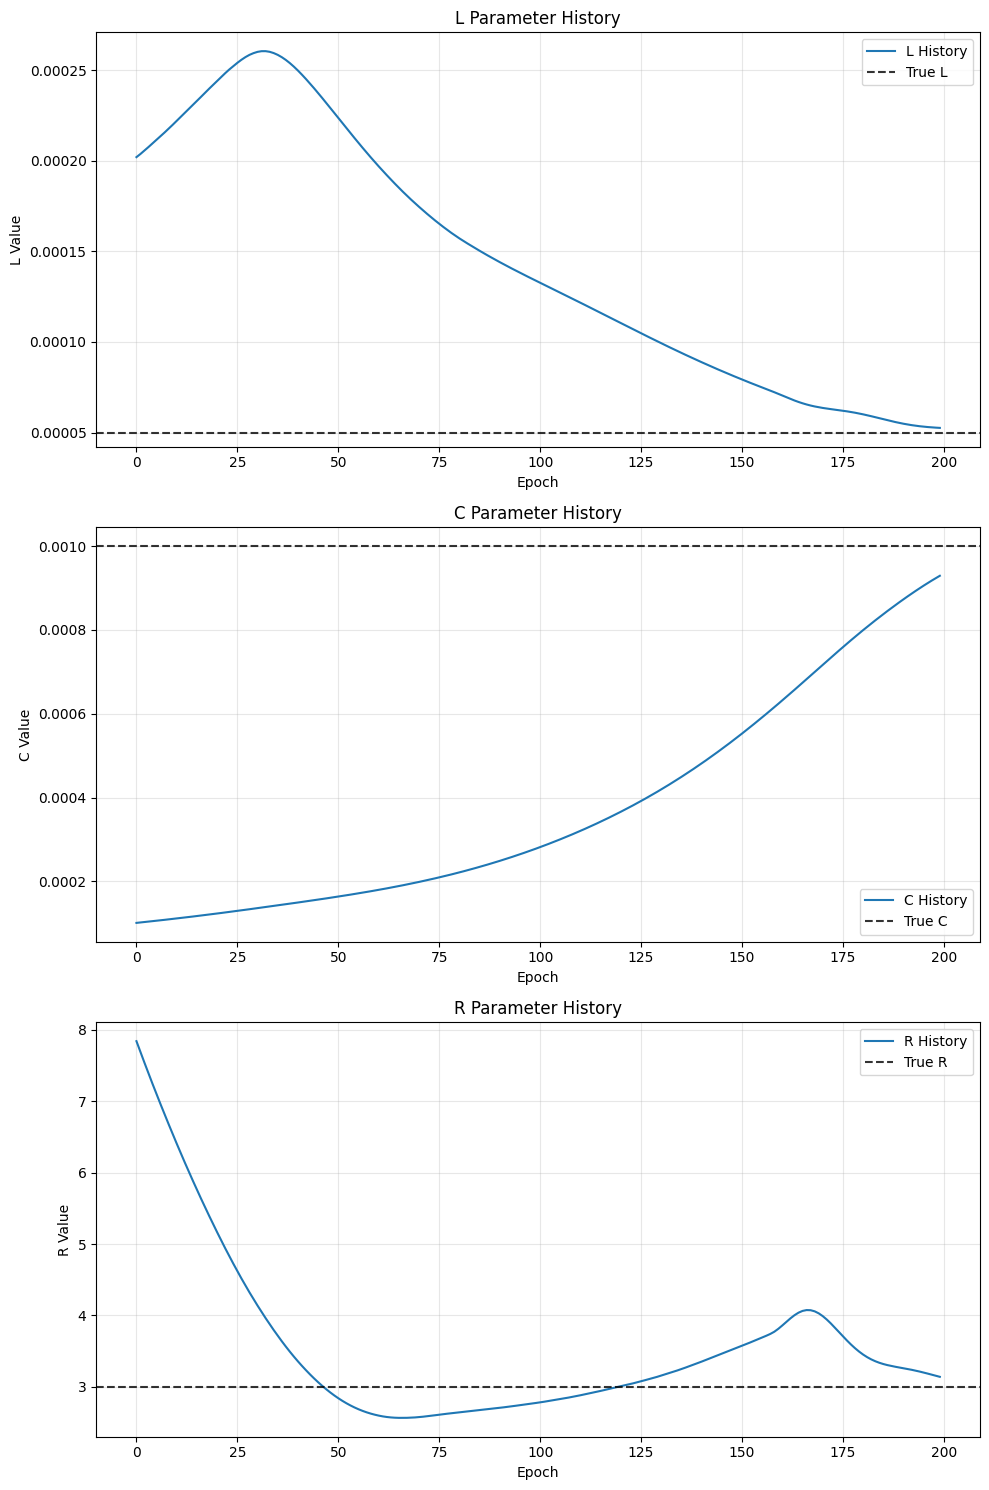

In [14]:
# 各パラメータの遷移
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=L_true, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=C_true, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=R_true, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()